In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
!unzip train.zip

# Load metadata

This assumes that the file train.zip has been unzipped in the current directory.  If needed, insert code here to load the data from your computer.

In [0]:
import json
import numpy as np


# # load metadata
# with open("train.json", 'r') as f:
#     metadata = json.load(f)
# n_claims = len(metadata)

def preprocess_articles():

    from nltk.tokenize import sent_tokenize
    import nltk
    nltk.download('punkt')
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    # load metadata
    with open("train.json", 'r') as f:
        metadata = json.load(f)
    n_claims = len(metadata)

    # load related articles for each claim
    relevant_sentences = []
    for id in range(n_claims):
  
        if id % 500 == 0:
            print("Claims preprocessed: ",id)
        
        # retrieve related articles
        related_articles = metadata[id]['related_articles']
        articles = ""
        for article_id in related_articles:
            filename = "train_articles/" + str(article_id) + ".txt"
            # concatenate related articles
            with open(filename, 'r') as text_file:
                text = text_file.read()
                articles = articles + "\n" + text

        # split articles into sentences
        sentences = sent_tokenize(articles)

        # append claim to articles
        sentences.append(metadata[id]['claim'])

        # vectorize sentences based on tf-idf
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(sentences)
    
        # measure similarity between claim and each sentence
        similarity =  X[-1,:] @ np.transpose(X[:-2,:])
        similarity = similarity.todense()

        # find top 5 sentences with greatest similarity
        sorted_index = np.argsort(similarity)
        top_sentences = []
        for i in range(1,min(5,sorted_index.shape[1])+1):
            top_sentences.append(sentences[sorted_index[0,-i]])
        relevant_sentences.append(top_sentences)

   
    return metadata, relevant_sentences

metadata, relevant_sentences = preprocess_articles()
print("Metadata of claim 0:")
print(metadata[0]['claim'])
print("Relevant sentences of claim 0:")
print(relevant_sentences[0])


In [0]:
!pip install bpemb
from bpemb import BPEmb
n_embedding_dims = 100
bpemb_en = BPEmb(lang="en", dim=n_embedding_dims)

def sampleClaim(metadata): 
    id = random.randint(0, len(metadata) - 1)
    claim = metadata[id]["claim"]
    embedding = bpemb_en.embed(claim)
    embedding = np.reshape(embedding,(1, embedding.shape[0],embedding.shape[1]))
    label = metadata[id]["label"]
    label_tensor = torch.tensor([label], dtype=torch.long)
    claim_tensor = torch.tensor(embedding, dtype=torch.float)
    return claim_tensor, label_tensor, claim, label, id
  
def sampleClaimClaimant(metadata): 
    id = random.randint(0, len(metadata) - 1)
    claim = metadata[id]["claim"] + '\n'
    claimant = metadata[id]["claim"] + '\n'
    embedding = bpemb_en.embed(claim + claimant)
    embedding = np.reshape(embedding,(1, embedding.shape[0], embedding.shape[1]))
    label = metadata[id]["label"]
    label_tensor = torch.tensor([label], dtype=torch.long)
    claim_tensor = torch.tensor(embedding, dtype=torch.float)
    return claim_tensor, label_tensor, claim, label, id 
  
def sampleClaimClaimantSentence(metadata): 
    id = random.randint(0, len(metadata) - 1)
    claim = metadata[id]["claim"] + '\n'
    claimant = metadata[id]["claim"] + '\n'
    sentences = '\n'.join(relevant_sentences[id]) + '\n'
    embedding = bpemb_en.embed(claim + claimant + sentences)
    embedding = np.reshape(embedding,(1, embedding.shape[0], embedding.shape[1]))
    label = metadata[id]["label"]
    label_tensor = torch.tensor([label], dtype=torch.long)
    claim_tensor = torch.tensor(embedding, dtype=torch.float)
    return claim_tensor, label_tensor, claim, label, id   



# Positional Encoder

In [0]:
import torch
import torch.nn as nn
import numpy as np
import random
import math
from torch.autograd import Variable

class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 500):
        super().__init__()
        self.d_model = d_model
        
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                math.sin(pos / (10000 ** (i/d_model)))
                pe[pos, i + 1] = \
                math.cos(pos / (10000 ** (((i + 1))/d_model)))
                
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
 
    
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + Variable(self.pe[:,:seq_len], \
        requires_grad=False)
        return x

#Multi-Head Attention

In [0]:
import torch.nn.functional as F
class MultiHeadAttention(nn.Module):
  
    def attention(self, q, k, v, d_k, mask=None, dropout=None):
        scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
        if mask is not None:
          mask = mask.unsqueeze(1)
          scores = scores.masked_fill(mask == 0, -1e9)
        scores = F.softmax(scores, dim=-1)

        if dropout is not None:
          scores = dropout(scores)

        output = torch.matmul(scores, v)
        return output
      
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
        
        # perform linear operation and split into h heads
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * h * sl * d_model
       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
		    # calculate attention using function we will define next
        scores = self.attention(q, k, v, self.d_k, dropout=self.dropout)
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous()\
        .view(bs, -1, self.d_model)
        
        output = self.out(concat)
    
        return output


#Feed-Forward Networks

In [0]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__() 
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

#Normalization

In [0]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

#Encoder layer with one multi-head attention layer and one  feed-forward layer

In [0]:
import copy
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

# We can then build a convenient cloning function that can generate multiple layers:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

# Encoder with multiple encoder layers

In [0]:
class Encoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super().__init__()
        self.N = N
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, embedding, mask=None):
        x = self.pe(embedding)
        for i in range(self.N):
            x = self.layers[i](x, mask)
        return self.norm(x)

# Transformer

In [0]:
class Transformer(nn.Module):
    def __init__(self, d_model, N, heads):
        super().__init__()
        self.encoder = Encoder(d_model, N, heads)
    def forward(self, embedding):
        e_outputs = self.encoder(embedding)
        # apply maxpooling
        output = e_outputs.max(1)[0]
        return output

# Classifier

In [0]:
class Classifier(nn.Module):
    def __init__(self, t_output_size, output_size):
        super(Classifier, self).__init__()
        self.input_size = t_output_size
        self.i2o = nn.Linear(self.input_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, t_output):
        output = self.i2o(t_output)
        output = self.softmax(output)
        return output

In [0]:

train_data = metadata[:10000]
for i in range(10):
  train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaimClaimant(train_data)
  print(train_line_tensor.size(1))




62
22
60
76
54
168
28
54
60
42


# Training procedure


In [0]:
def train(category_tensor, line_tensor, update=True):
    transformerOptimizer.zero_grad()
    classifierOptimizer.zero_grad()

    t_output = transformer(line_tensor)
    output = classifier(t_output)

    loss = criterion(output, category_tensor)
    if update:
        loss.backward()
        transformerOptimizer.step()
        classifierOptimizer.step()
        
    return output, loss.item()

# Train Transformer and plot results

In [0]:
import time
import math

n_categories = 3
n_heads = 5
n_encoder_layers = 1
n_iters = 100000
plot_every = 1000
criterion = nn.NLLLoss()
learning_rate = 1e-4
train_data = metadata[:10000]
test_data = metadata[10000:]

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

train_cumulative_loss_1 = 0
test_cumulative_loss_1 = 0
average_train_accuracy_1 = 0
average_test_accuracy_1 = 0
all_train_losses_1 = []
all_train_accuracies_1 = []
all_test_losses_1 = []
all_test_accuracies_1 = []

train_cumulative_loss_2 = 0
test_cumulative_loss_2 = 0
average_train_accuracy_2 = 0
average_test_accuracy_2 = 0
all_train_losses_2 = []
all_train_accuracies_2 = []
all_test_losses_2 = []
all_test_accuracies_2 = []

train_cumulative_loss_3 = 0
test_cumulative_loss_3 = 0
average_train_accuracy_3 = 0
average_test_accuracy_3 = 0
all_train_losses_3 = []
all_train_accuracies_3 = []
all_test_losses_3 = []
all_test_accuracies_3 = []

# For part 1
start = time.time()
transformer = Transformer(n_embedding_dims, n_encoder_layers, n_heads)
classifier = Classifier(n_embedding_dims, n_categories)
transformerOptimizer = torch.optim.Adam(transformer.parameters(), lr=learning_rate)
classifierOptimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)
count = 0
for iter in range(1, n_iters + 1):
    train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaim(train_data)
    while(train_line_tensor.size(1) > 50):
      train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaim(train_data)
    train_output, train_loss = train(train_category_tensor, train_line_tensor)    
    top_train_value, top_train_index = train_output.topk(1)
    train_guess_category = top_train_index[0].item()
    train_cumulative_loss_1 += train_loss
    train_accuracy = 1 if train_guess_category == train_category else 0
    average_train_accuracy_1 = (average_train_accuracy_1 * count + train_accuracy) / (count+1)
    
    test_line_tensor, test_category_tensor, test_line, test_category, test_id = sampleClaim(test_data)
    while(test_line_tensor.size(1) > 50):
      test_line_tensor, test_category_tensor, test_line, test_category, test_id = sampleClaim(test_data)
    test_output, test_loss = train(test_category_tensor, test_line_tensor, update=False)
    top_test_value, top_test_index = test_output.topk(1)
    test_guess_category = top_test_index[0].item()
    test_cumulative_loss_1 += test_loss
    test_accuracy = 1 if test_guess_category == test_category else 0
    average_test_accuracy_1 = (average_test_accuracy_1 * count + test_accuracy) / (count+1)
    count += 1

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        train_correct = '✓' if train_guess_category == train_category else '✗ (%s)' % train_category
        print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy_1, train_cumulative_loss_1 / plot_every, train_correct))
#         print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss_1 / plot_every, train_line, train_guess_category, train_correct))
        test_correct = '✓' if test_guess_category == test_category else '✗ (%s)' % test_category
        print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy_1, test_cumulative_loss_1 / plot_every, test_correct))
#         print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy, test_cumulative_loss_1 / plot_every, test_line, test_guess_category, test_correct))
        all_train_losses_1.append(train_cumulative_loss_1 / plot_every)
        all_train_accuracies_1.append(average_train_accuracy_1)
        all_test_losses_1.append(test_cumulative_loss_1 / plot_every)
        all_test_accuracies_1.append(average_test_accuracy_1)
        train_cumulative_loss_1 = 0
        average_train_accuracy_1 = 0
        test_cumulative_loss_1 = 0
        average_test_accuracy_1 = 0
        count = 0
        
# For part 2
start = time.time()
transformer = Transformer(n_embedding_dims, n_encoder_layers, n_heads)
classifier = Classifier(n_embedding_dims, n_categories)
transformerOptimizer = torch.optim.Adam(transformer.parameters(), lr=learning_rate)
classifierOptimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)
count = 0
for iter in range(1, n_iters + 1):
    train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaimClaimant(train_data)
    while(train_line_tensor.size(1) > 100):
      train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaimClaimant(train_data)
    train_output, train_loss = train(train_category_tensor, train_line_tensor)    
    top_train_value, top_train_index = train_output.topk(1)
    train_guess_category = top_train_index[0].item()
    train_cumulative_loss_2 += train_loss
    train_accuracy = 1 if train_guess_category == train_category else 0
    average_train_accuracy_2 = (average_train_accuracy_2 * count + train_accuracy) / (count+1)
    
    test_line_tensor, test_category_tensor, test_line, test_category, test_id = sampleClaimClaimant(test_data)
    while(test_line_tensor.size(1) > 100):
      test_line_tensor, test_category_tensor, test_line, test_category, test_id = sampleClaimClaimant(test_data)
    test_output, test_loss = train(test_category_tensor, test_line_tensor, update=False)
    top_test_value, top_test_index = test_output.topk(1)
    test_guess_category = top_test_index[0].item()
    test_cumulative_loss_2 += test_loss
    test_accuracy = 1 if test_guess_category == test_category else 0
    average_test_accuracy_2 = (average_test_accuracy_2 * count + test_accuracy) / (count+1)
    count += 1

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        train_correct = '✓' if train_guess_category == train_category else '✗ (%s)' % train_category
        print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy_2, train_cumulative_loss_2 / plot_every, train_correct))
#         print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss_2 / plot_every, train_line, train_guess_category, train_correct))
        test_correct = '✓' if test_guess_category == test_category else '✗ (%s)' % test_category
        print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy_2, test_cumulative_loss_2 / plot_every, test_correct))
#         print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy, test_cumulative_loss_2 / plot_every, test_line, test_guess_category, test_correct))
        all_train_losses_2.append(train_cumulative_loss_2 / plot_every)
        all_train_accuracies_2.append(average_train_accuracy_2)
        all_test_losses_2.append(test_cumulative_loss_2 / plot_every)
        all_test_accuracies_2.append(average_test_accuracy_2)
        train_cumulative_loss_2 = 0
        average_train_accuracy_2 = 0
        test_cumulative_loss_2 = 0
        average_test_accuracy_2 = 0
        count = 0
        
# For Part 3
start = time.time()
transformer = Transformer(n_embedding_dims, n_encoder_layers, n_heads)
classifier = Classifier(n_embedding_dims, n_categories)
transformerOptimizer = torch.optim.Adam(transformer.parameters(), lr=learning_rate)
classifierOptimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)
count = 0
for iter in range(1, n_iters + 1):
    train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaimClaimantSentence(train_data)
    while(train_line_tensor.size(1) > 500):
      train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaimClaimantSentence(train_data)
    train_output, train_loss = train(train_category_tensor, train_line_tensor)    
    top_train_value, top_train_index = train_output.topk(1)
    train_guess_category = top_train_index[0].item()
    train_cumulative_loss_3 += train_loss
    train_accuracy = 1 if train_guess_category == train_category else 0
    average_train_accuracy_3 = (average_train_accuracy_3 * count + train_accuracy) / (count+1)
    
    test_line_tensor, test_category_tensor, test_line, test_category, test_id = sampleClaimClaimantSentence(test_data)
    while(test_line_tensor.size(1) > 500):
      test_line_tensor, test_category_tensor, test_line, test_category, test_id = sampleClaimClaimantSentence(test_data)
    test_output, test_loss = train(test_category_tensor, test_line_tensor, update=False)
    top_test_value, top_test_index = test_output.topk(1)
    test_guess_category = top_test_index[0].item()
    test_cumulative_loss_3 += test_loss
    test_accuracy = 1 if test_guess_category == test_category else 0
    average_test_accuracy_3 = (average_test_accuracy_3 * count + test_accuracy) / (count+1)
    count += 1

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        train_correct = '✓' if train_guess_category == train_category else '✗ (%s)' % train_category
        print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy_3, train_cumulative_loss_3 / plot_every, train_correct))
#         print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss_3 / plot_every, train_line, train_guess_category, train_correct))
        test_correct = '✓' if test_guess_category == test_category else '✗ (%s)' % test_category
        print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy_3, test_cumulative_loss_3 / plot_every, test_correct))
#         print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy, test_cumulative_loss_3 / plot_every, test_line, test_guess_category, test_correct))
        all_train_losses_3.append(train_cumulative_loss_3 / plot_every)
        all_train_accuracies_3.append(average_train_accuracy_3)
        all_test_losses_3.append(test_cumulative_loss_3 / plot_every)
        all_test_accuracies_3.append(average_test_accuracy_3)
        train_cumulative_loss_3 = 0
        average_train_accuracy_3 = 0
        test_cumulative_loss_3 = 0
        average_test_accuracy_3 = 0
        count = 0


Train: 1000  1% (0m 53s) average_accuracy=0.4940 average_loss=0.9905 ✓
Test: 1000  1% (0m 53s) average_accuracy=0.4600 average_loss=0.9764 ✓
Train: 2000  2% (1m 45s) average_accuracy=0.5420 average_loss=0.9392 ✓
Test: 2000  2% (1m 45s) average_accuracy=0.4960 average_loss=0.9544 ✓
Train: 3000  3% (2m 37s) average_accuracy=0.5620 average_loss=0.9388 ✓
Test: 3000  3% (2m 37s) average_accuracy=0.5000 average_loss=0.9766 ✗ (2)
Train: 4000  4% (3m 29s) average_accuracy=0.5790 average_loss=0.9132 ✓
Test: 4000  4% (3m 29s) average_accuracy=0.5050 average_loss=0.9614 ✓
Train: 5000  5% (4m 20s) average_accuracy=0.5890 average_loss=0.9235 ✗ (2)
Test: 5000  5% (4m 20s) average_accuracy=0.5030 average_loss=0.9566 ✗ (1)


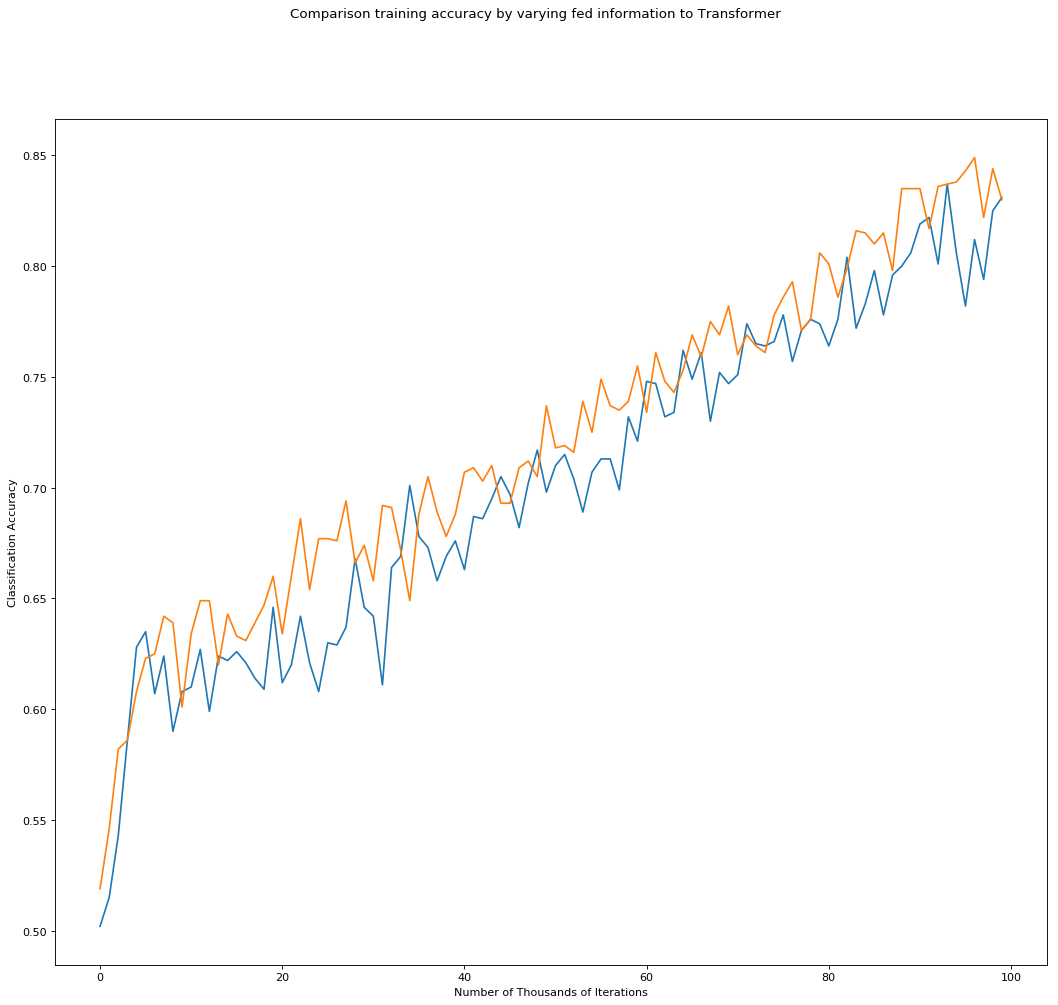

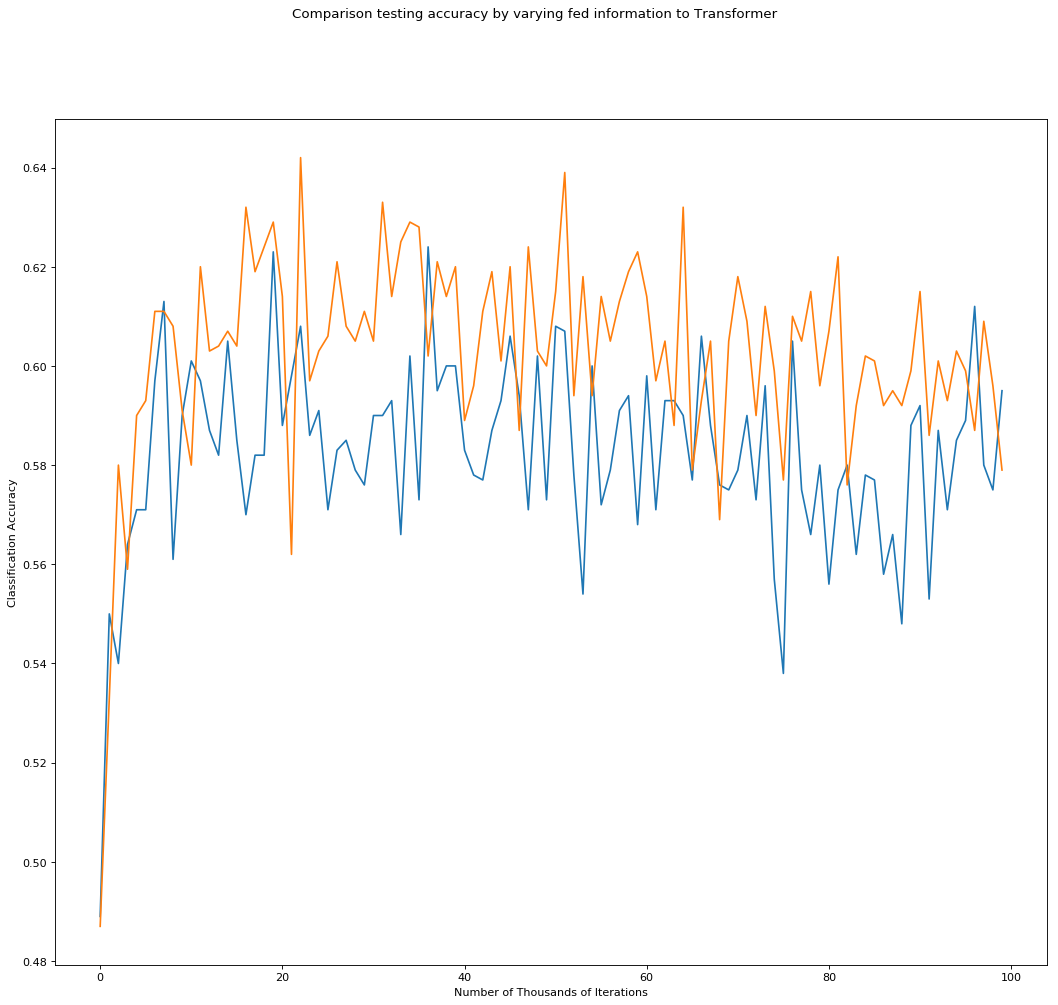

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig=plt.figure(figsize=(16, 14), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(all_train_accuracies_1)
plt.plot(all_train_accuracies_2)
# plt.plot(all_train_accuracies_3)
plt.suptitle('Comparison training accuracy by varying fed information to Transformer')
plt.ylabel('Classification Accuracy')
plt.xlabel('Number of Thousands of Iterations')
# plt.gca().legend(('Claim only', 'Claim and Claimant', 'Claim, Claimant and 5 Supporting Sentences'))

fig=plt.figure(figsize=(16, 14), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(all_test_accuracies_1)
plt.plot(all_test_accuracies_2)
# plt.plot(all_test_accuracies_3)
plt.suptitle('Comparison testing accuracy by varying fed information to Transformer')
plt.ylabel('Classification Accuracy')
plt.xlabel('Number of Thousands of Iterations')
# plt.gca().legend(('Claim only', 'Claim and Claimant', 'Claim, Claimant and 5 Supporting Sentences'))
plt.show()